In [1]:
import keras
import sys
sys.path.append('C:/Users/320060820/experiments/')
import os
import fxp_quantize
import model_data

from model_gen import inception_cnn
import copy

import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tnrange, tqdm_notebook

# to restart layer numbering
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [5]:
def brute_force_analysis(model_obj, name, test_data, layer_names, bw_range, f_range, 
                         float_model_acc, fix_quant=False, parameters=None, eval_metric='acc_drop'):
    
    if fix_quant and parameters is None:
        raise ValueError('parameters is empty')
    
    if not isinstance(layer_names, list):
        layer_names = [layer_names]
        
    for i in range(len(layer_names)):
        
        scores_matrix = []
        
        for j in tnrange(len(bw_range), desc=f'BW Layer {layer_names[i]}', leave=False):
            
            scores_row = []
            for k in tqdm_notebook(range(len(f_range)), desc='F', leave=False):
                
                quant_params = {
                    layer_names[i]: [bw_range[j], f_range[k]]
                }
                if fix_quant:
                    quant_params = {**quant_params, **parameters}
                
                df_model = model_data.Model(name, test_data, model=model_obj.get_fxp_model(quant_params))
                scores_row.append(df_model.evaluate_accuracy()[1])
                
            scores_matrix.append(scores_row)
            
        scores = np.array(scores_matrix)

        if i == 0:
            model_scores = scores
        else:
            model_scores = np.dstack((model_scores, scores))
        
        print(f'Layer {layer_names[i]} done.')
    
    if eval_metric == 'acc_drop':
        model_scores = (float_model_acc - model_scores) / float_model_acc
        
    elif eval_metric == 'acc_ratio':
        model_scores = model_scores / float_model_acc
        
    elif eval_metric == 'quant_acc':
        pass
    
    return model_scores

In [3]:
def plot_results(scores, layer_names, rows, columns, figsize, shrink, bw_range, f_range, invert=False, vmax=None):
    
    if len(scores.shape) < 3:
        scores = np.expand_dims(scores, axis=3)
    fig, ax = plt.subplots(rows, columns, figsize=figsize)
    cbar_ax = fig.add_axes([.91, 0.1, .02, 0.8])
    if rows == 1 and columns == 1:
        ax = [ax]
    else:
        ax = ax.flatten()
    vmin = scores.min()
    if vmax is None:
        vmax = scores.max()
    else:
        vmax=vmax
    t = np.arange(0.0, vmax, 0.1).tolist()
    for i in range(scores.shape[2]):
        sns.heatmap(scores[:, :, i], annot=True, fmt='.3f', ax=ax[i], xticklabels=f_range, 
                    yticklabels=bw_range, vmin = vmin, vmax=vmax, cbar_ax=cbar_ax)#, cbar_kws={"ticks":t})
#         sns.heatmap(scores[:, :, i], annot=True, fmt='.2f', vmin=vmin, vmax=vmax, cbar_ax=cbar_ax)
        ax[i].set_xlabel('Fractional offset')
        ax[i].set_ylabel('Bitwidth')
        ax[i].set_title(f'Layer {layer_names[i]}')
        if invert:
            ax[i].invert_yaxis()
    if rows*columns - scores.shape[2] != 0:
        for i in range(1, rows*columns - scores.shape[2] + 1):
            fig.delaxes(ax[-i])

In [7]:
input_shape = (96, 96, 1)
num_outputs = 10 # number of classes
path_trained_weights = 'C:/Users/320060820/experiments/test_models/mnist_df/inception_v3_model_batchnorm_w.h5'
output_path = 'C:/Users/320060820/experiments/outputs/Brute_Force_Analysis/Activations/DF_MNIST/'
name = 'mnist_df'

from test_models.mnist_df import data
_, test_data = data.get_data()

df_mnist = inception_cnn.InceptionCNN(input_shape, num_outputs, 
                                      dropout=False, pool_layer_type='average',
                                      path_trained_weights=path_trained_weights)

In [11]:
bw_range = np.arange(1, 11, 1)
f_range = np.arange(-6, 5, 1)
layer_names = ['conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_4', 'conv2d_12', 'conv2d_13', 
               'conv2d_14', 'conv2d_17', 'conv2d_19', 'conv2d_20', 'conv2d_21'] + ['binary']
t_layer_names = ['conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_12', 'conv2d_13', 
                 'conv2d_17', 'conv2d_19', 'binary']
vmax = 0.1
model = model_data.Model(name, test_data, model=df_mnist.get_float_model())
float_model_acc = model.evaluate_accuracy()[1]

In [15]:
scores_1_ = brute_force_analysis(df_mnist, name, test_data, t_layer_names[:1], bw_range, np.arange(2, 9, 1), float_model_acc)
np.save(output_path + 'scores_1_layer1', arr=scores_1)

Layer conv2d_1 done.


C:\Users\320060820\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  after removing the cwd from sys.path.


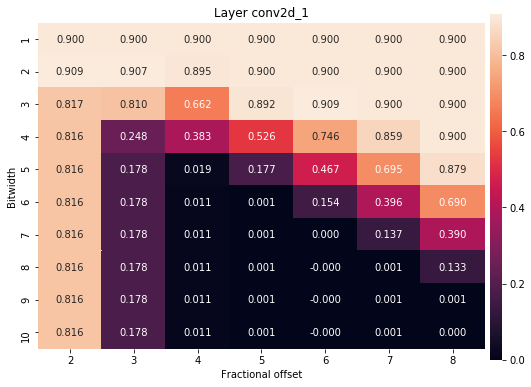

In [18]:
plot_results(scores_1_, t_layer_names[:1], 1, 1, (8, 6), 0.8, bw_range, np.arange(2, 9, 1))

In [13]:
scores_1 = brute_force_analysis(df_mnist, name, test_data, t_layer_names, bw_range, f_range, float_model_acc)
np.save(output_path + 'scores_1', arr=scores_1)

Layer conv2d_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_12 done.


Layer conv2d_13 done.


Layer conv2d_17 done.


Layer conv2d_19 done.


Layer binary done.


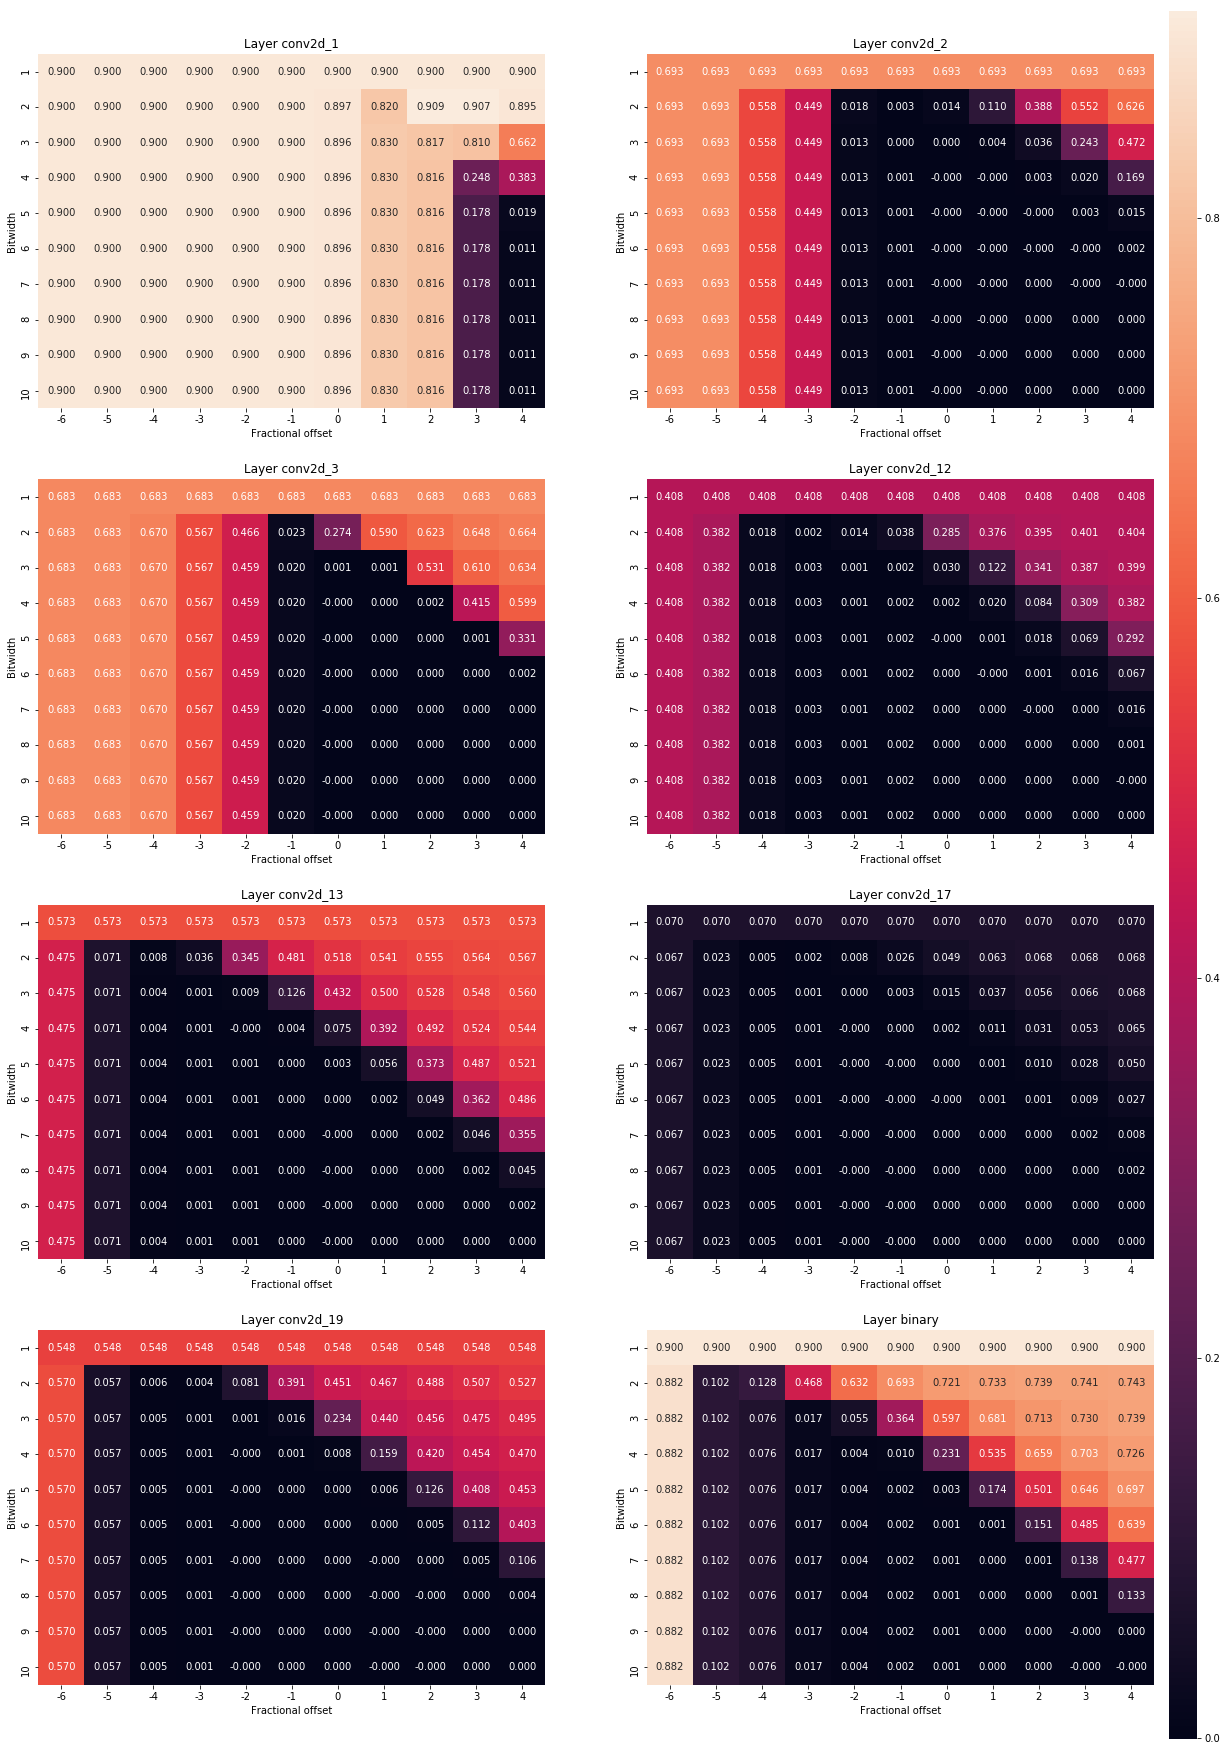

In [14]:
plot_results(scores_1, t_layer_names, 4, 2, (20, 30), 0.8, bw_range, f_range)

In [19]:
params = {
    'conv2d_1': [8, 6]
}
scores_2 = brute_force_analysis(df_mnist, name, test_data, t_layer_names[1:], bw_range, f_range, float_model_acc,
                                fix_quant=True, parameters=params)
np.save(output_path + 'scores_2', arr=scores_2)

Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_12 done.


Layer conv2d_13 done.


Layer conv2d_17 done.


Layer conv2d_19 done.


Layer binary done.


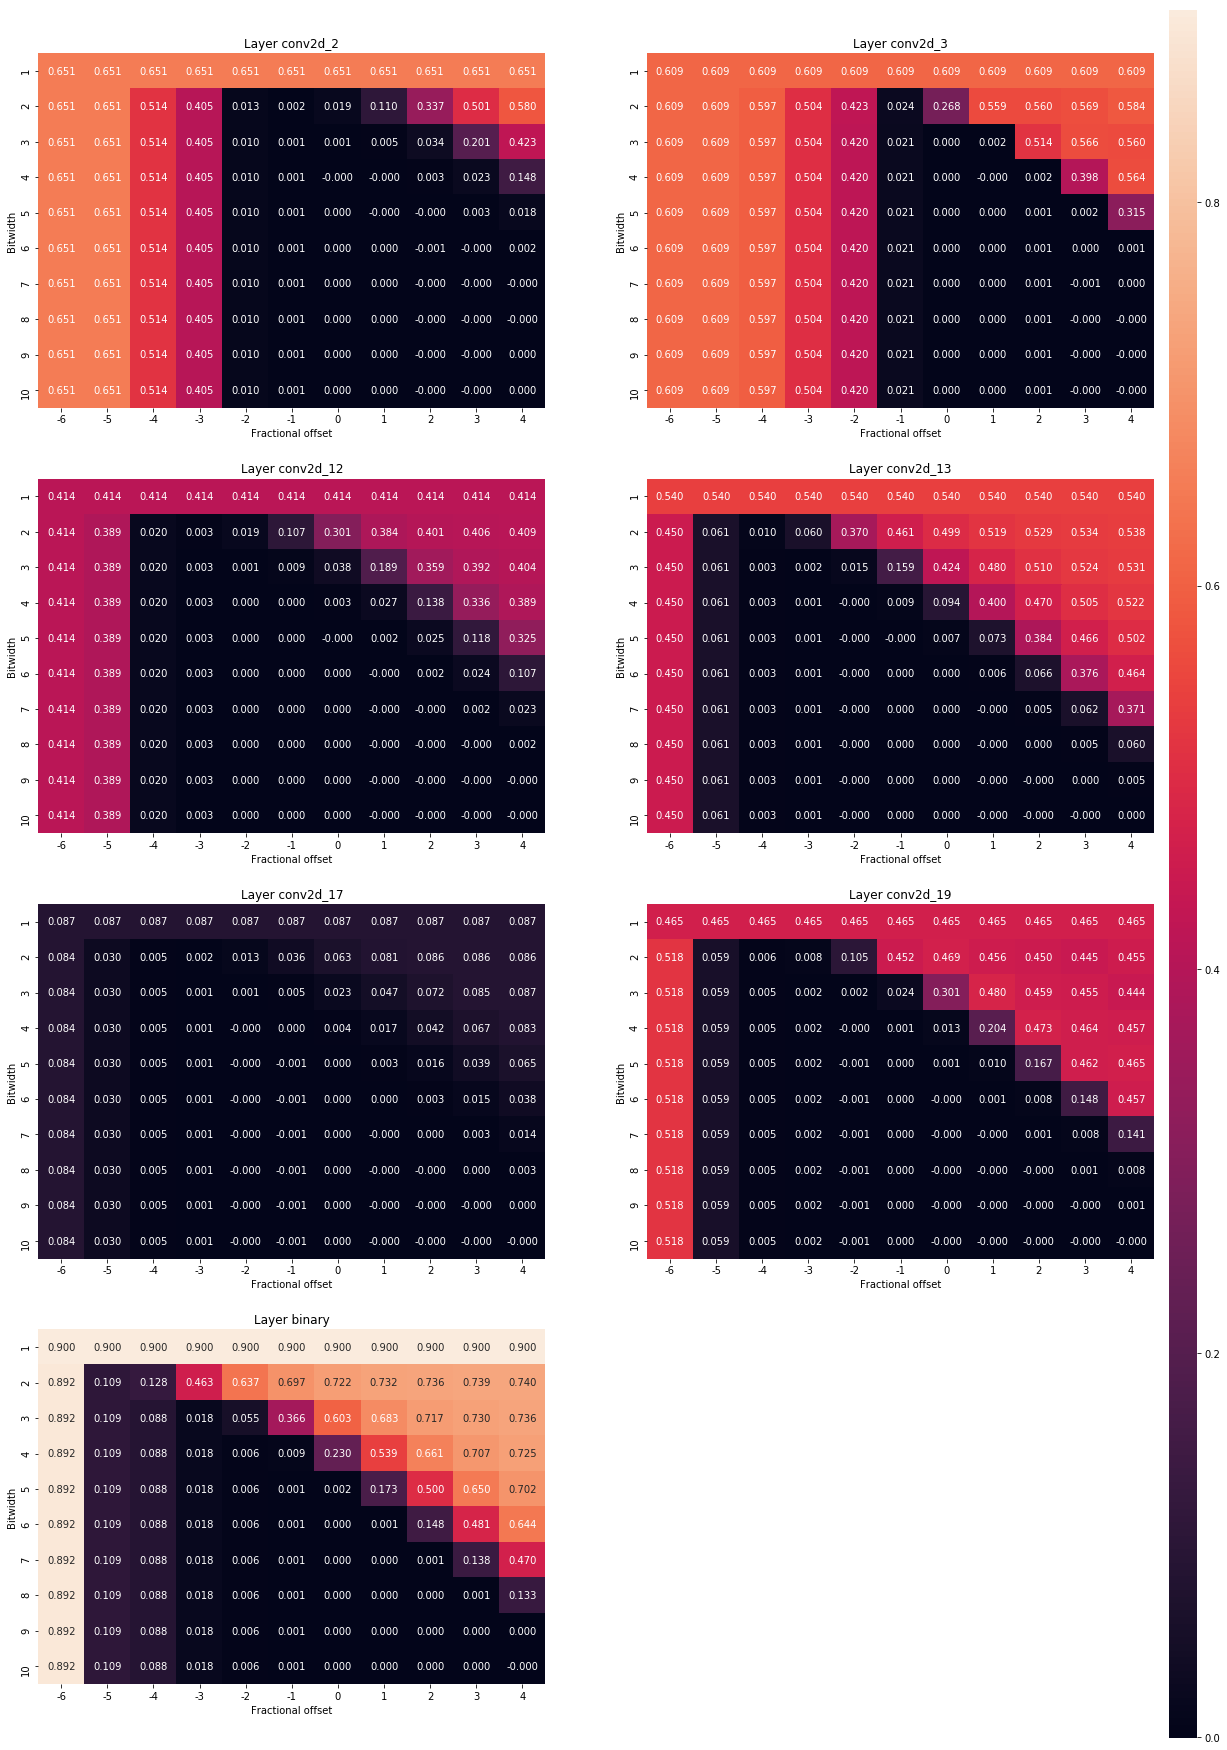

In [20]:
plot_results(scores_2, t_layer_names[1:], 4, 2, (20, 30), 0.8, bw_range, f_range)

In [21]:
bw_range = np.arange(1, 9, 1)
f_range = np.arange(-6, 3, 1)

In [22]:
params = {
    'conv2d_1': [8, 6], 
    'conv2d_2': [4, 0]
}
scores_3 = brute_force_analysis(df_mnist, name, test_data, t_layer_names[2:], bw_range, f_range, float_model_acc,
                                fix_quant=True, parameters=params)
np.save(output_path + 'scores_3', arr=scores_3)

Layer conv2d_3 done.


Layer conv2d_12 done.


Layer conv2d_13 done.


Layer conv2d_17 done.


Layer conv2d_19 done.


Layer binary done.


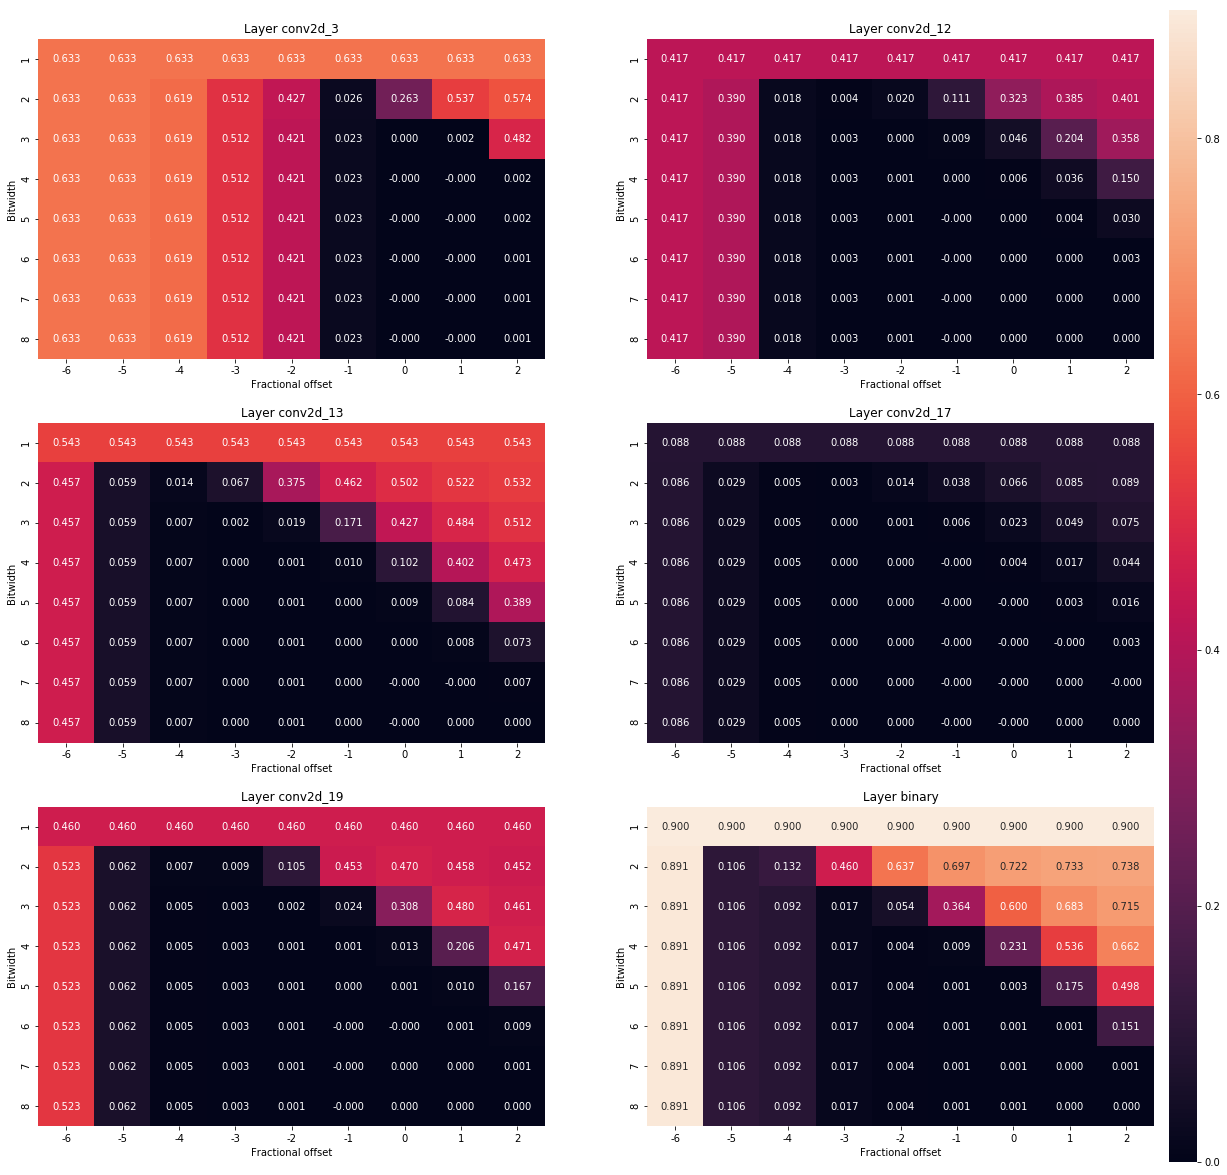

In [24]:
plot_results(scores_3, t_layer_names[2:], 3, 2, (20, 20), 0.8, bw_range, f_range)

In [25]:
params = {
    'conv2d_1': [8, 6], 
    'conv2d_2': [4, 0], 
    'conv2d_3': [4, 0]
}
scores_4 = brute_force_analysis(df_mnist, name, test_data, t_layer_names[3:], bw_range, f_range, float_model_acc,
                                fix_quant=True, parameters=params)
np.save(output_path + 'scores_4', arr=scores_4)

Layer conv2d_12 done.


Layer conv2d_13 done.


Layer conv2d_17 done.


Layer conv2d_19 done.


Layer binary done.


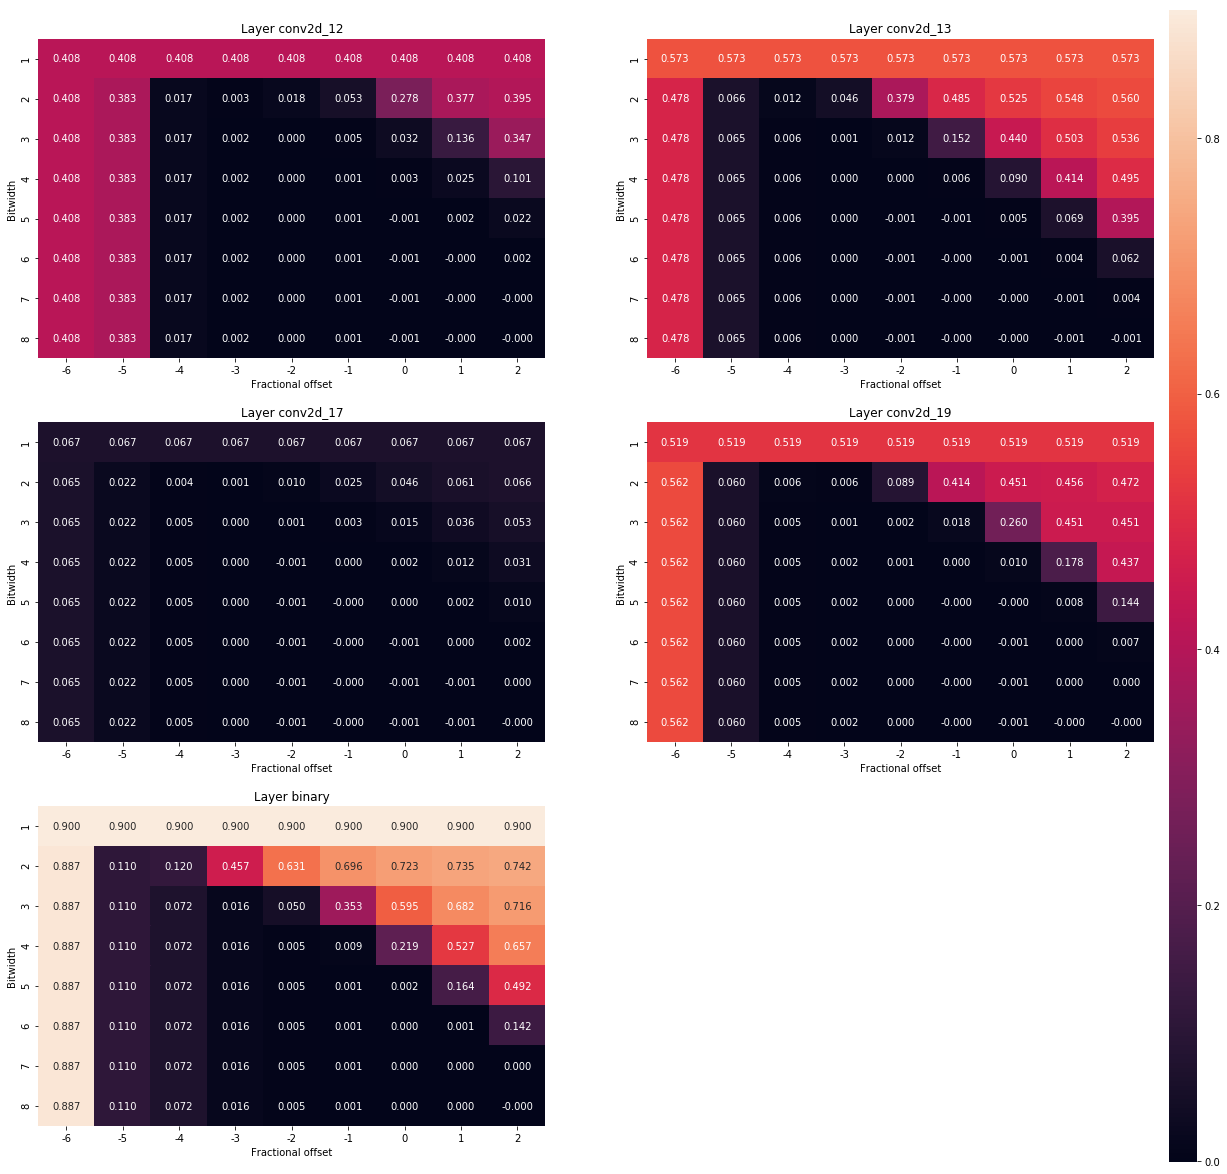

In [26]:
plot_results(scores_4, t_layer_names[3:], 3, 2, (20, 20), 0.8, bw_range, f_range)

In [27]:
params = {
    'conv2d_1': [8, 6], 
    'conv2d_2': [4, 0], 
    'conv2d_3': [4, 0],
    'conv2d_12': [5, 0]
}
scores_5 = brute_force_analysis(df_mnist, name, test_data, t_layer_names[4:], bw_range, f_range, float_model_acc,
                                fix_quant=True, parameters=params)
np.save(output_path + 'scores_5', arr=scores_5)

Layer conv2d_13 done.


Layer conv2d_17 done.


Layer conv2d_19 done.


Layer binary done.


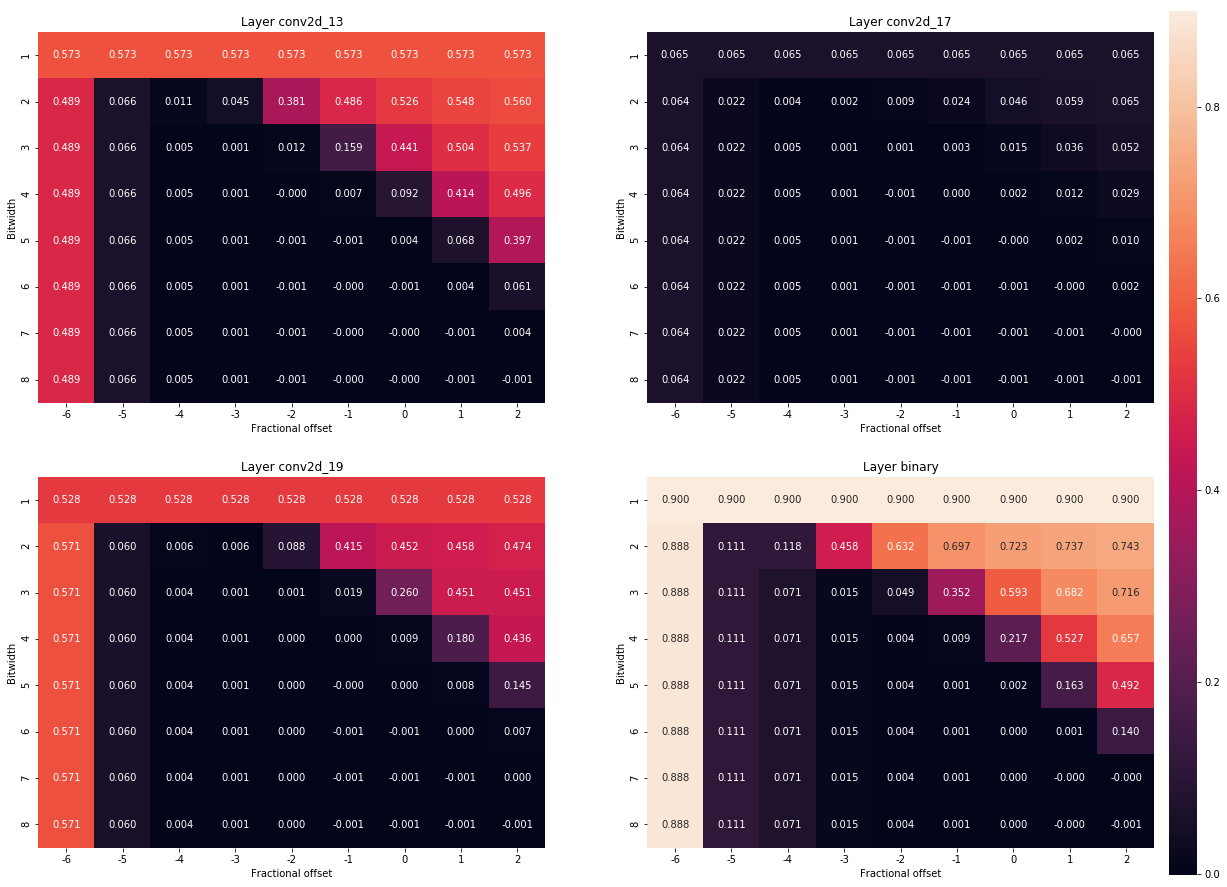

In [28]:
plot_results(scores_5, t_layer_names[4:], 2, 2, (20, 15), 0.8, bw_range, f_range)

In [37]:
params = {
    'conv2d_1': [8, 6], 
    'conv2d_2': [4, 0], 
    'conv2d_3': [4, 0],
    'conv2d_12': [5, 0],
    'conv2d_13': [5, -1]
}
scores_6 = brute_force_analysis(df_mnist, name, test_data, t_layer_names[5:], bw_range, f_range, float_model_acc,
                                fix_quant=True, parameters=params)
np.save(output_path + 'scores_6', arr=scores_6)

Layer conv2d_17 done.


Layer conv2d_19 done.


Layer binary done.


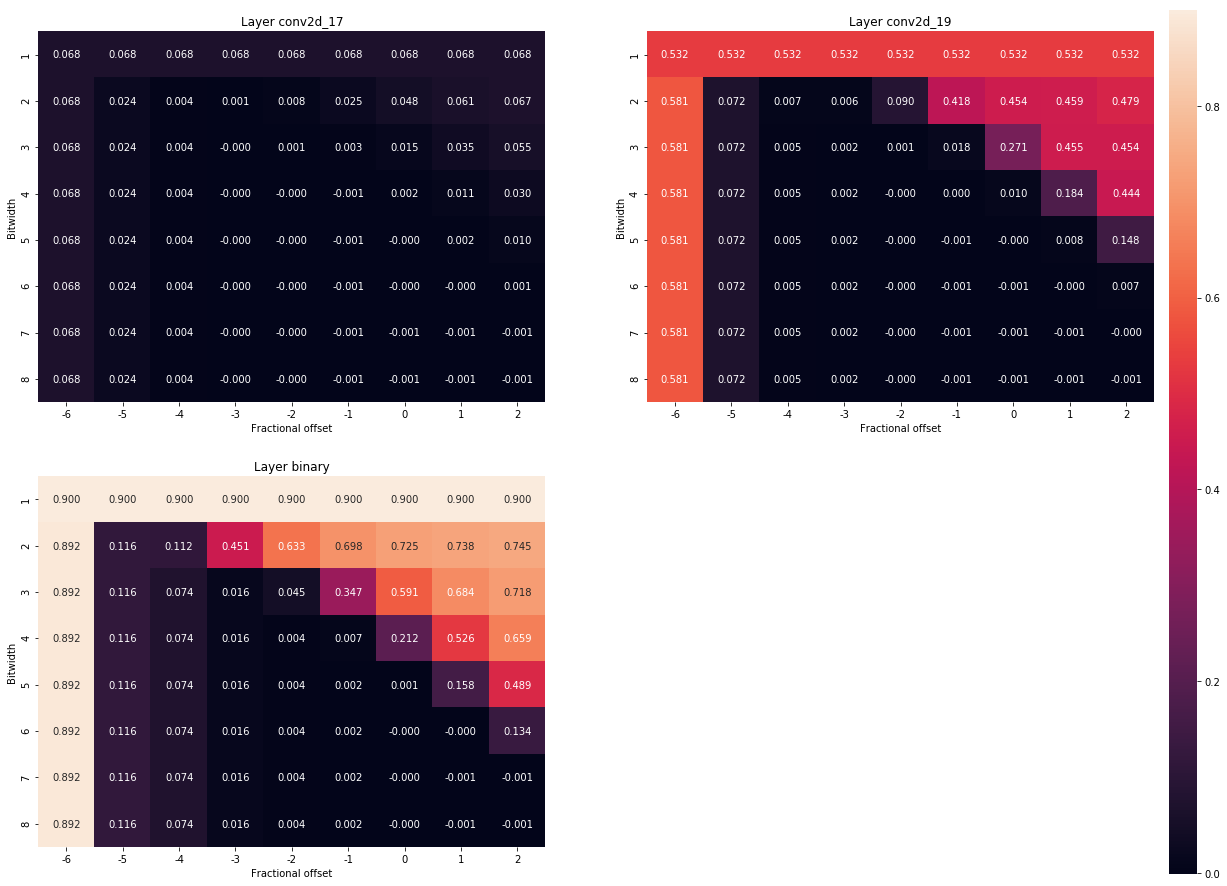

In [38]:
plot_results(scores_6, t_layer_names[5:], 2, 2, (20, 15), 0.8, bw_range, f_range)

In [39]:
params = {
    'conv2d_1': [8, 6], 
    'conv2d_2': [4, 0], 
    'conv2d_3': [4, 0],
    'conv2d_12': [5, 0],
    'conv2d_13': [5, -1],
    'conv2d_17': [3, -2]
}
scores_7 = brute_force_analysis(df_mnist, name, test_data, t_layer_names[6:], bw_range, f_range, float_model_acc,
                                fix_quant=True, parameters=params)
np.save(output_path + 'scores_7', arr=scores_7)

Layer conv2d_19 done.


Layer binary done.


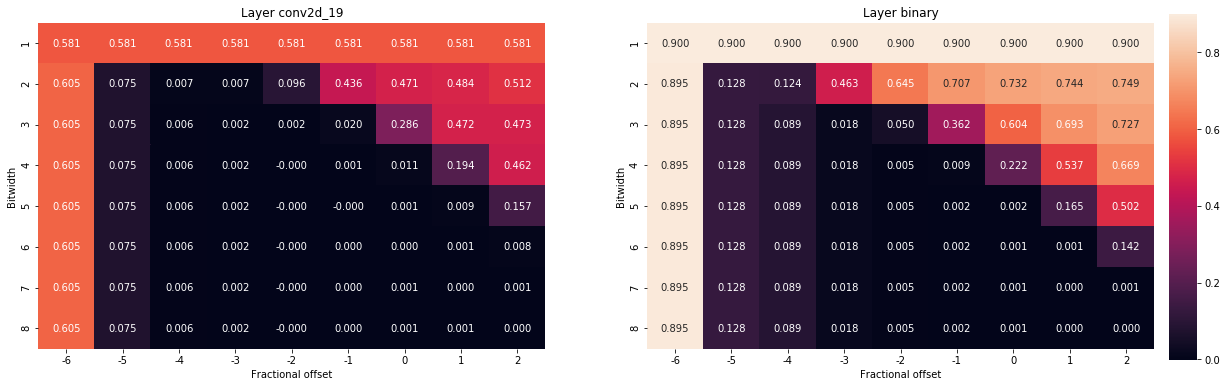

In [41]:
plot_results(scores_7, t_layer_names[6:], 1, 2, (20, 6), 0.8, bw_range, f_range)

In [40]:
params = {
    'conv2d_1': [8, 6], 
    'conv2d_2': [4, 0], 
    'conv2d_3': [4, 0],
    'conv2d_12': [5, 0],
    'conv2d_13': [5, -1],
    'conv2d_17': [3, -2],
    'conv2d_19': [4, -2]
}
scores_8 = brute_force_analysis(df_mnist, name, test_data, t_layer_names[7:], bw_range, f_range, float_model_acc,
                                fix_quant=True, parameters=params)
np.save(output_path + 'scores_8', arr=scores_8)

Layer binary done.


C:\Users\320060820\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  after removing the cwd from sys.path.


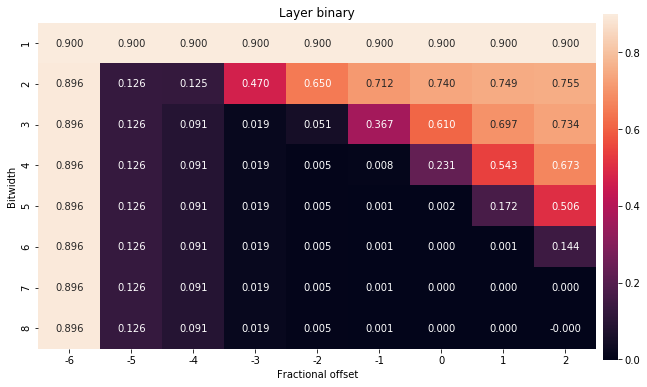

In [42]:
plot_results(scores_8, t_layer_names[7:], 1, 1, (10, 6), 0.8, bw_range, f_range)

### Quantizing in reverse

In [29]:
params = {
    'binary': [7, 1]
}
scores_r1 = brute_force_analysis(df_mnist, name, test_data, t_layer_names[:-1], bw_range, f_range, float_model_acc,
                                fix_quant=True, parameters=params)
np.save(output_path + 'scores_r1', arr=scores_r1)

Layer conv2d_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_12 done.


Layer conv2d_13 done.


Layer conv2d_17 done.


Layer conv2d_19 done.


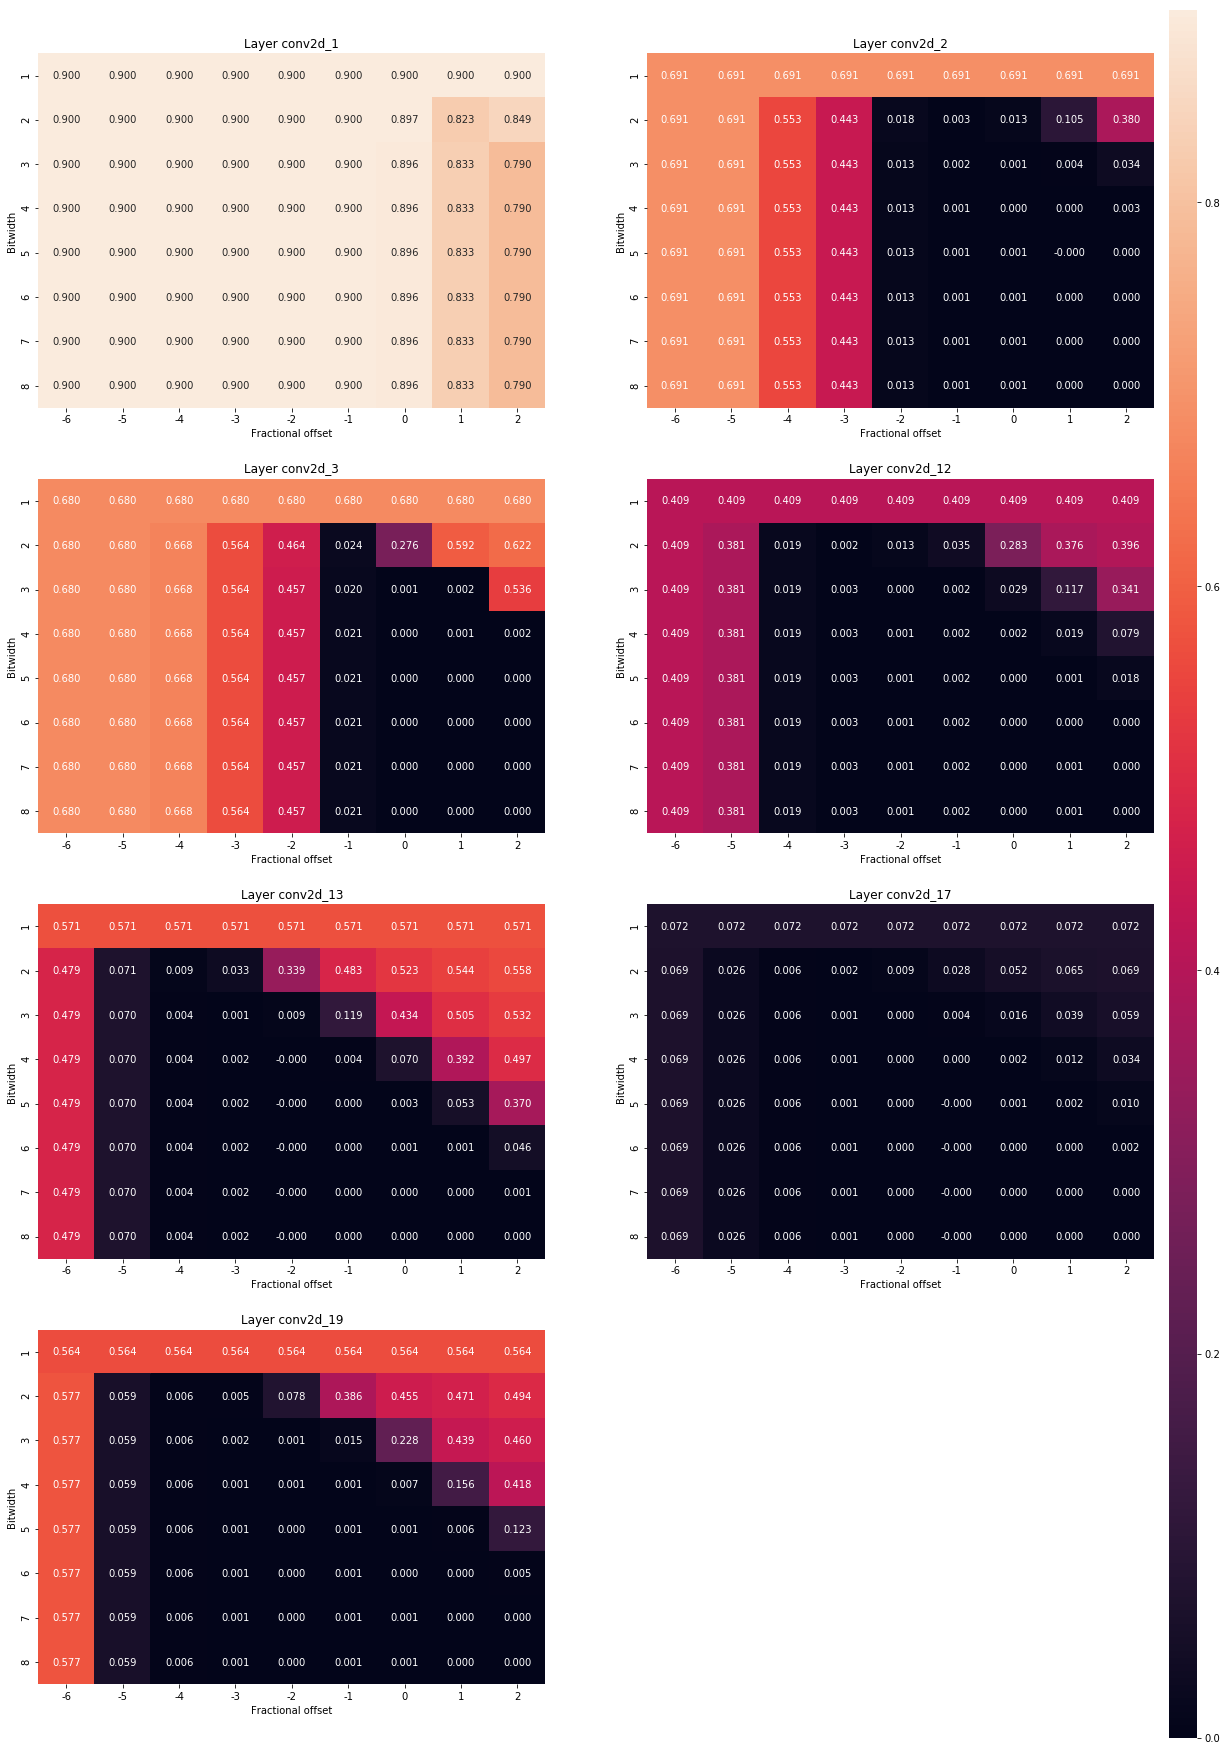

In [34]:
plot_results(scores_r1, t_layer_names[:-1], 4, 2, (20, 30), 0.8, bw_range, f_range)

In [30]:
params = {
    'binary': [7, 1],
    'conv2d_19': [4, -2]
}
scores_r2 = brute_force_analysis(df_mnist, name, test_data, t_layer_names[:-2], bw_range, f_range, float_model_acc,
                                fix_quant=True, parameters=params)
np.save(output_path + 'scores_r2', arr=scores_r2)

Layer conv2d_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_12 done.


Layer conv2d_13 done.


Layer conv2d_17 done.


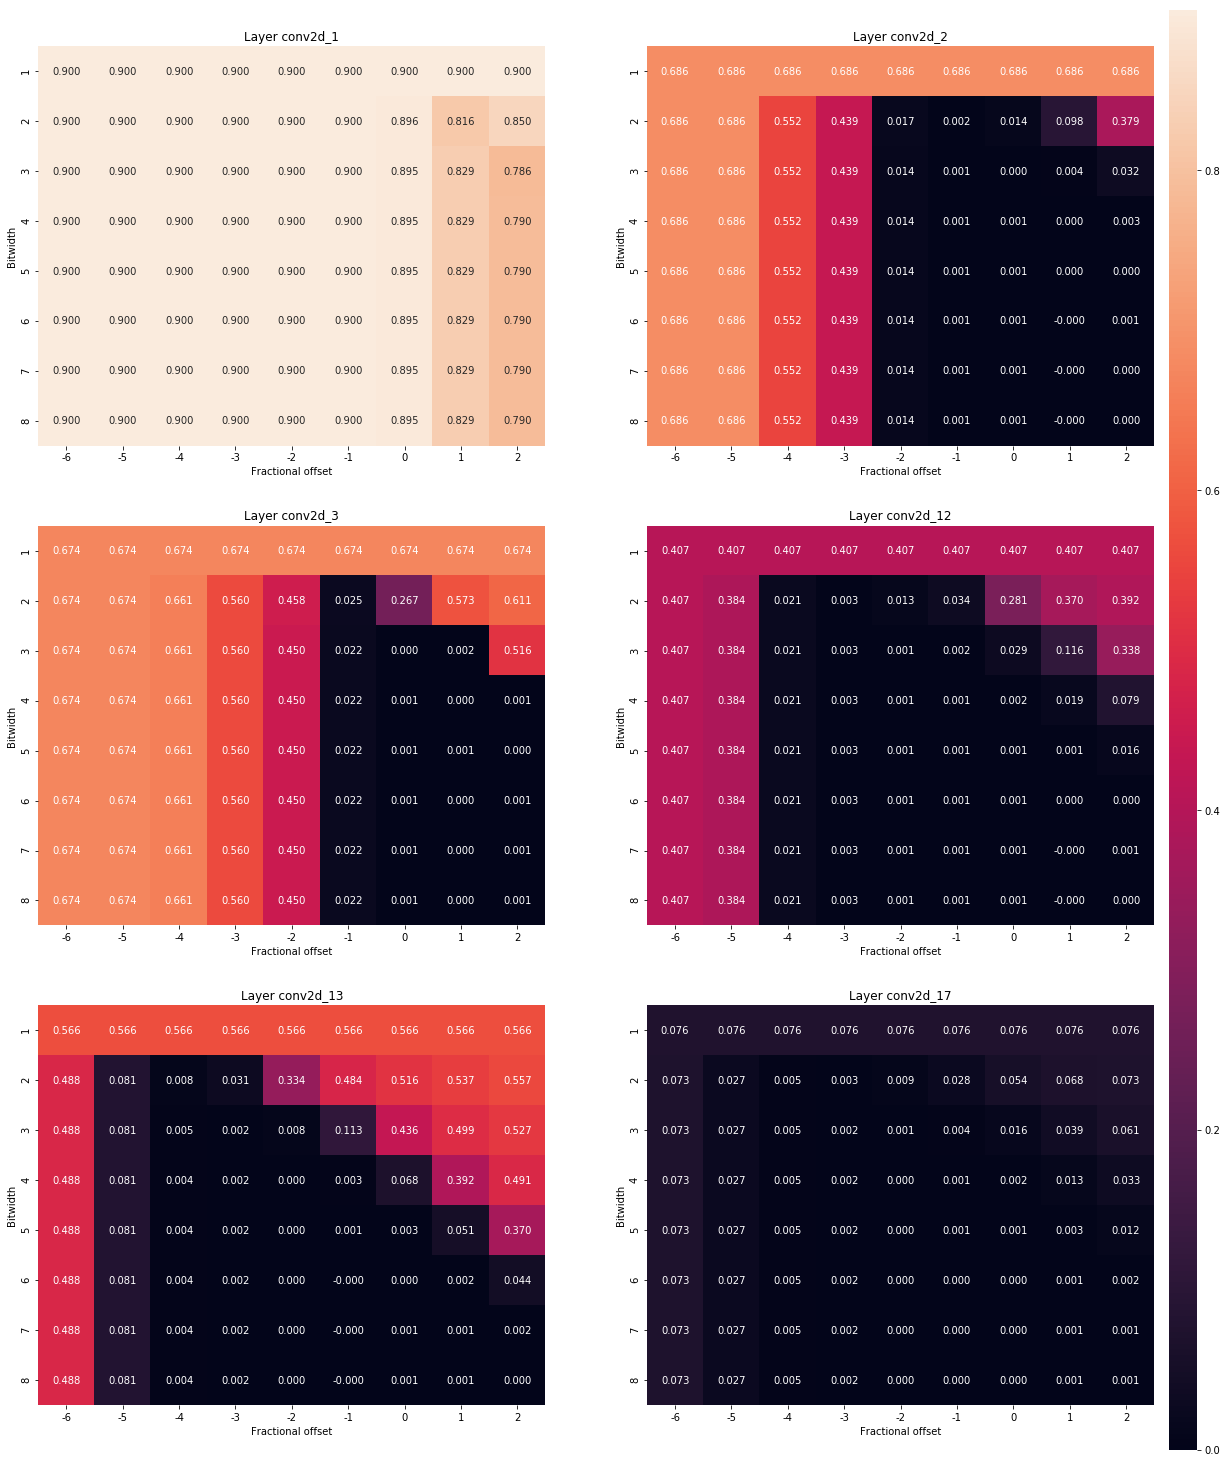

In [35]:
plot_results(scores_r2, t_layer_names[:-2], 3, 2, (20, 25), 0.8, bw_range, f_range)

In [43]:
params = {
    'binary': [7, 1],
    'conv2d_19': [4, -2],
    'conv2d_17': [3, -2]
}
scores_r3 = brute_force_analysis(df_mnist, name, test_data, t_layer_names[:-3], bw_range, f_range, float_model_acc,
                                fix_quant=True, parameters=params)
np.save(output_path + 'scores_r3', arr=scores_r3)

Layer conv2d_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_12 done.


Layer conv2d_13 done.


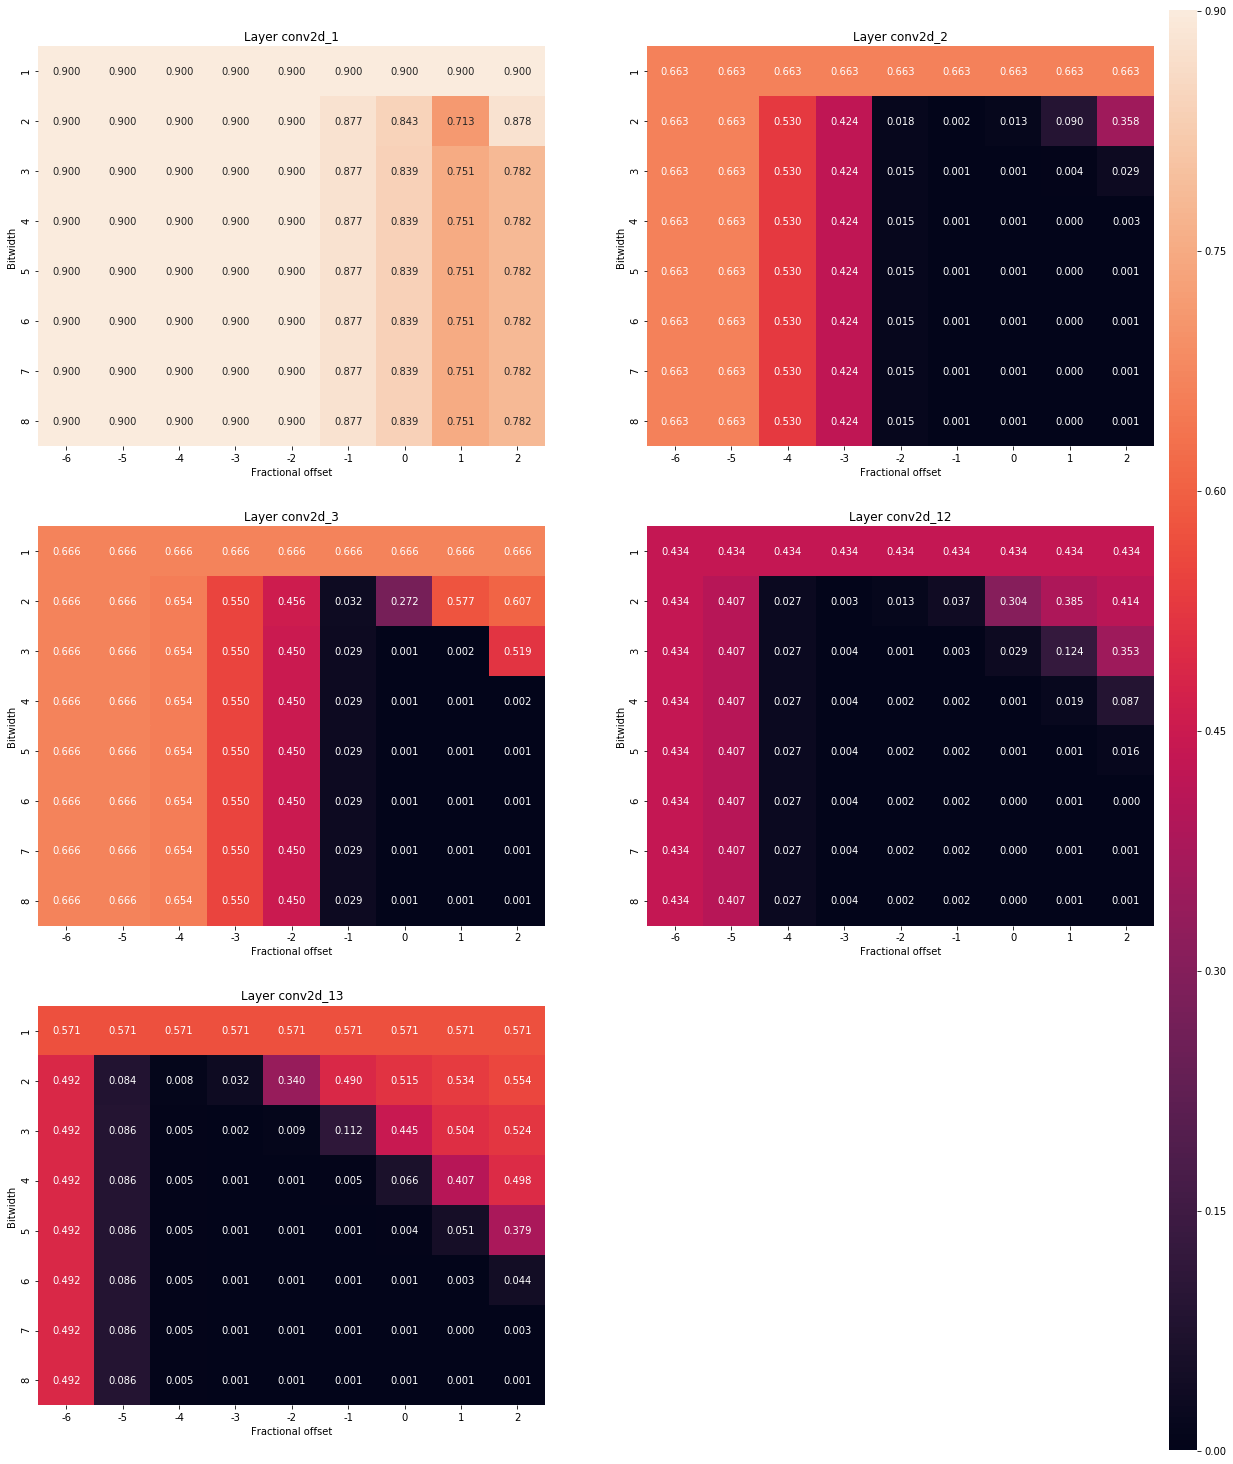

In [44]:
plot_results(scores_r3, t_layer_names[:-3], 3, 2, (20, 25), 0.8, bw_range, f_range)

In [45]:
params = {
    'binary': [7, 1],
    'conv2d_19': [4, -2],
    'conv2d_17': [3, -2],
    'conv2d_13': [5, -1]
}
scores_r4 = brute_force_analysis(df_mnist, name, test_data, t_layer_names[:-4], bw_range, f_range, float_model_acc,
                                fix_quant=True, parameters=params)
np.save(output_path + 'scores_r4', arr=scores_r4)

Layer conv2d_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_12 done.


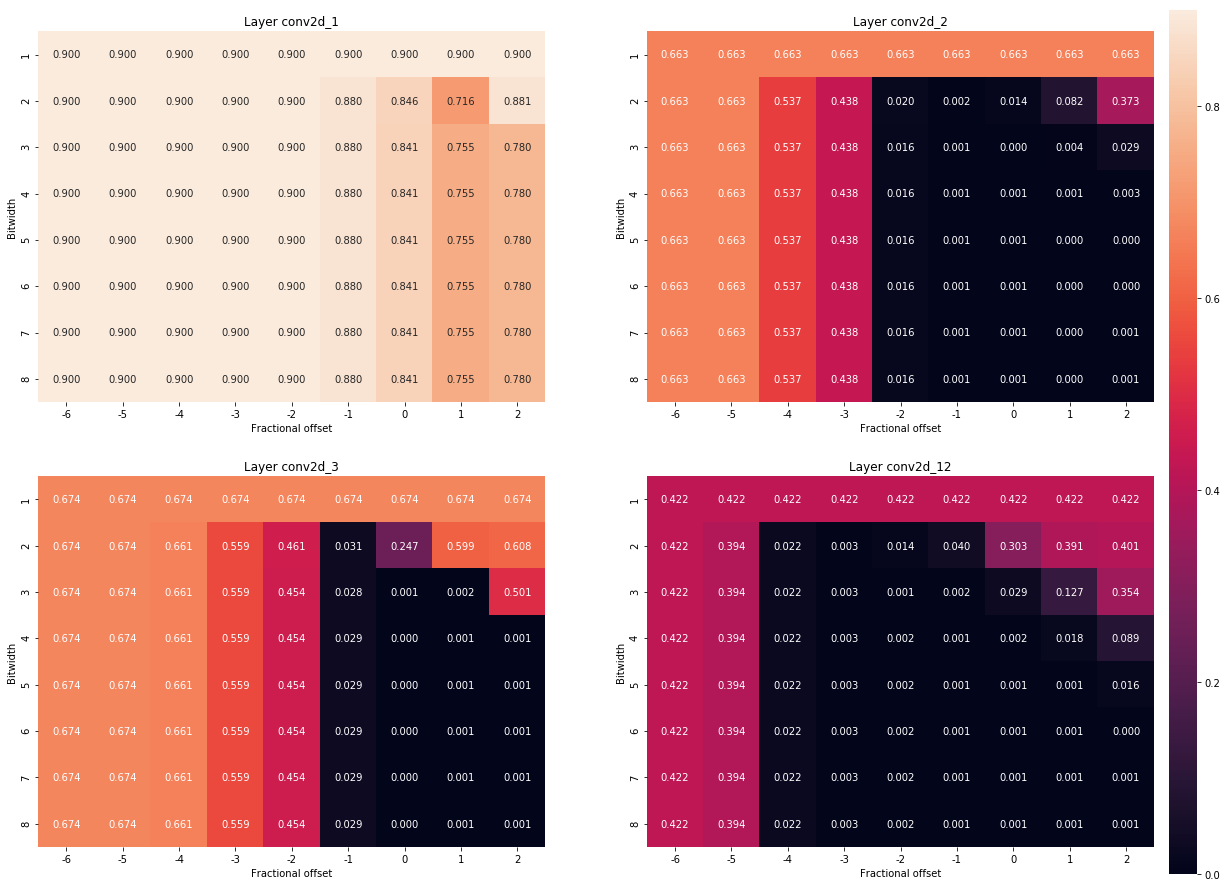

In [50]:
plot_results(scores_r4, t_layer_names[:-4], 2, 2, (20, 15), 0.8, bw_range, f_range)

In [46]:
params = {
    'binary': [7, 1],
    'conv2d_19': [4, -2],
    'conv2d_17': [3, -2],
    'conv2d_13': [5, -1],
    'conv2d_12': [5, 0],
}
scores_r5 = brute_force_analysis(df_mnist, name, test_data, t_layer_names[:-5], bw_range, f_range, float_model_acc,
                                fix_quant=True, parameters=params)
np.save(output_path + 'scores_r5', arr=scores_r5)

Layer conv2d_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


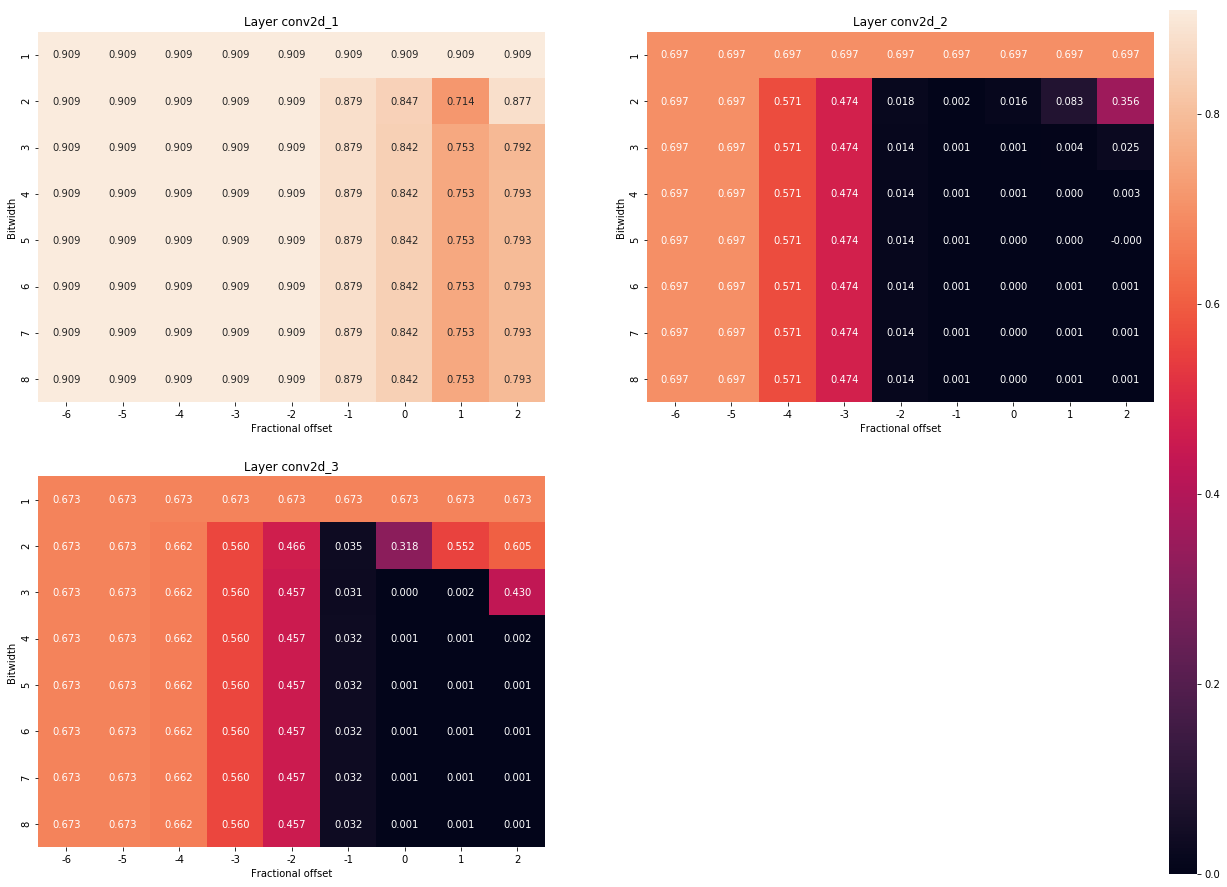

In [52]:
plot_results(scores_r5, t_layer_names[:-5], 2, 2, (20, 15), 0.8, bw_range, f_range)

In [47]:
params = {
    'binary': [7, 1],
    'conv2d_19': [4, -2],
    'conv2d_17': [3, -2],
    'conv2d_13': [5, -1],
    'conv2d_12': [5, 0],
    'conv2d_3': [4, 0]
}
scores_r6 = brute_force_analysis(df_mnist, name, test_data, t_layer_names[:-6], bw_range, f_range, float_model_acc,
                                fix_quant=True, parameters=params)
np.save(output_path + 'scores_r6', arr=scores_r6)

Layer conv2d_1 done.


Layer conv2d_2 done.


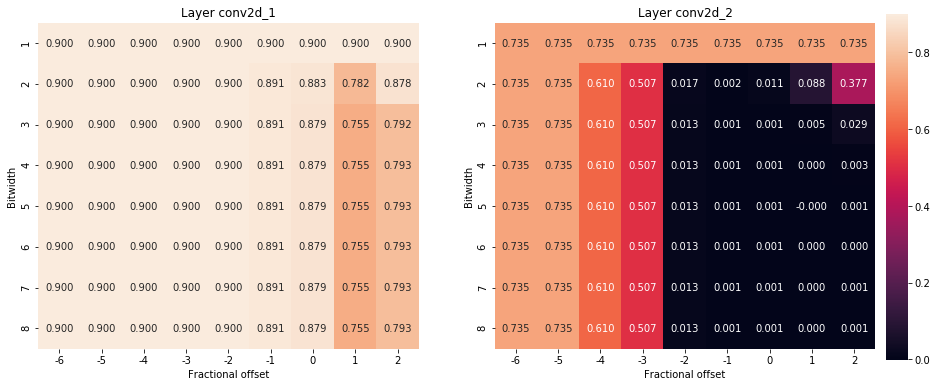

In [55]:
plot_results(scores_r6, t_layer_names[:-6], 1, 2, (15, 6), 0.8, bw_range, f_range)

In [58]:
params = {
    'binary': [7, 1],
    'conv2d_19': [4, -2],
    'conv2d_17': [3, -2],
    'conv2d_13': [5, -1],
    'conv2d_12': [5, 0],
    'conv2d_3': [4, 0],
    'conv2d_2': [4, 0]
}
scores_r7 = brute_force_analysis(df_mnist, name, test_data, t_layer_names[:-7], bw_range, np.arange(0, 7, 1), float_model_acc,
                                fix_quant=True, parameters=params)
np.save(output_path + 'scores_r7', arr=scores_r7)

Layer conv2d_1 done.


C:\Users\320060820\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  after removing the cwd from sys.path.


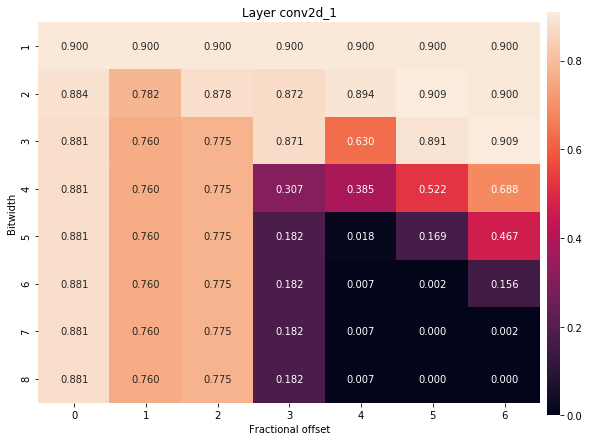

In [59]:
plot_results(scores_r7, t_layer_names[:-7], 1, 1, (9, 7), 0.8, bw_range, np.arange(0, 7, 1))